In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.manual_seed(1)

In [4]:
EPOCH = 1
BATCH_SIZE = 64
TIME_STEP = 28
INPUT_SIZE = 28
LR = 0.01
DOWNLOAD_MNIST = False

/home/wangyx/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/wangyx/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000, 28, 28])
torch.Size([60000])


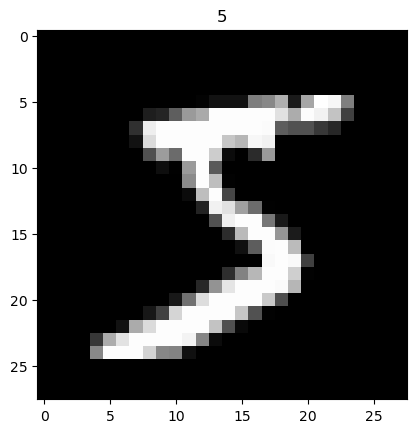

In [6]:
# Mnist digital dataset
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,                         # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,            # download it if you don't have it
)

# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [7]:
# Data Loader for easy mini-batch return in training
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./mnist', train=False, transform=transforms.ToTensor())
test_x = Variable(test_data.test_data, volatile=True).type(torch.FloatTensor)[:2000]/255.
test_y = test_data.test_labels.numpy().squeeze()[:2000]    # convert to numpy array

/tmp/ipykernel_213245/3772626168.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  test_x = Variable(test_data.test_data, volatile=True).type(torch.FloatTensor)[:2000]/255.


In [17]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        self.rnn = nn.LSTM(
            input_size = INPUT_SIZE,
            hidden_size = 64,
            num_layers = 1,
            batch_first = True,
        )
        
        self.out = nn.Linear(64, 10)
        
    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)    # None represents zero initial hidden state
        
        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

In [18]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [19]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

In [29]:
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 28, 28))    # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                     # batch y
        
        output = rnn(b_x)                     # rnn output
        loss = loss_func(output, b_y)         # cross entropy loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 50 == 0:
            test_output = rnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, ' | train loss: %.4f' % loss.data, ' | test accuracy: %.2f' % accuracy)

Epoch:  0  | train loss: 2.3124  | test accuracy: 0.10
Epoch:  0  | train loss: 0.9899  | test accuracy: 0.59
Epoch:  0  | train loss: 0.5737  | test accuracy: 0.80
Epoch:  0  | train loss: 0.4363  | test accuracy: 0.82
Epoch:  0  | train loss: 0.4659  | test accuracy: 0.88
Epoch:  0  | train loss: 0.2721  | test accuracy: 0.91
Epoch:  0  | train loss: 0.3030  | test accuracy: 0.90
Epoch:  0  | train loss: 0.2563  | test accuracy: 0.93
Epoch:  0  | train loss: 0.1789  | test accuracy: 0.92
Epoch:  0  | train loss: 0.1371  | test accuracy: 0.94
Epoch:  0  | train loss: 0.5374  | test accuracy: 0.92
Epoch:  0  | train loss: 0.1509  | test accuracy: 0.91
Epoch:  0  | train loss: 0.2815  | test accuracy: 0.93
Epoch:  0  | train loss: 0.0689  | test accuracy: 0.95
Epoch:  0  | train loss: 0.2403  | test accuracy: 0.93
Epoch:  0  | train loss: 0.2584  | test accuracy: 0.94
Epoch:  0  | train loss: 0.1178  | test accuracy: 0.94
Epoch:  0  | train loss: 0.1541  | test accuracy: 0.94
Epoch:  0 

In [30]:
# print 10 predictions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
